<a href="https://colab.research.google.com/github/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/7506R_TP2_GRUPO09_ENTREGA_N2_(redes_neuronales).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración inicial

Importamos e instalamos las bibliotecas necesarias.

In [52]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers.core import Dense  
from sklearn.metrics import (
    confusion_matrix,
    recall_score, 
    accuracy_score, 
    f1_score,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import KFold
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam

np.random.seed(1)
tf.random.set_seed(1)

### Funciones útiles

In [54]:
def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize = (12, 10))
    sns.heatmap(
        cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="GnBu", fmt="g"
    )
    plt.title("Matriz de confusión")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def print_clasification_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    print("\nClasification metrics\n")
    print("Accuracy: " + str(accuracy))
    print("Recall: " + str(recall))
    print("F1 score: " + str(f1))

def print_regression_metrics(target_test, precios_predichos):
    # Error cuadrático medio
    mse = mean_squared_error(
        y_true=target_test, y_pred=precios_predichos, squared=True
    )

    # Raíz del error cuadrático medio
    rmse = mean_squared_error(
        y_true=target_test, y_pred=precios_predichos, squared=False
    )

    # Score R2
    r2 = r2_score(target_test, precios_predichos)

    print("\nRegression metrics\n")
    print(f"El error (mse) de test es: {mse}")
    print(f"El error (rmse) de test es: {rmse}")
    print(f"El score R2 es: {r2}")

Importamos los datasets que se utilizarán para trabajar.

In [55]:
dataset_train_clasificacion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_train_feature.csv?raw=True")
dataset_test_clasificacion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_test_feature.csv?raw=True")

dataset_train_regresion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_train_feature.csv?raw=True")
dataset_test_regresion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_test_feature.csv?raw=True")

In [56]:
y_train_clasificacion_categorico = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_train_target.csv?raw=True")
y_test_clasificacion_categorico = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_test_target.csv?raw=True")

y_train_regresion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_train_target.csv?raw=True")
y_test_regresion = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_test_target.csv?raw=True")


In [57]:
def preparar_dataset(dataset):
  dataset.drop("Unnamed: 0", axis = 1, inplace=True)
  dataset.drop("id", axis = 1, inplace=True)
  return dataset

def preparar_target(target):
  target.drop("Unnamed: 0", axis = 1, inplace=True)
  return target

dataset_train_clasificacion = preparar_dataset(dataset_train_clasificacion)
dataset_test_clasificacion = preparar_dataset(dataset_test_clasificacion)
dataset_train_regresion = preparar_dataset(dataset_train_regresion)
dataset_test_regresion = preparar_dataset(dataset_test_regresion)

y_train_clasificacion_categorico = preparar_target(y_train_clasificacion_categorico)
y_test_clasificacion_categorico = preparar_target(y_test_clasificacion_categorico)
y_train_regresion = preparar_target(y_train_regresion)
y_test_regresion = preparar_target(y_test_regresion)

Convertimos las categorías del target de clasificacion en categorías numéricas para poder utilizarlas en la red neuronal.

In [58]:
le = preprocessing.LabelEncoder()
y_train_clasificacion = le.fit_transform(y_train_clasificacion_categorico)
y_test_clasificacion = le.transform(y_test_clasificacion_categorico)


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Redes neuronales

Escalamos los datos para que performe mejor.

In [66]:
scaler_clasificacion = StandardScaler()
scaler_clasificacion.fit(dataset_train_clasificacion)

scaler_regresion = StandardScaler()
scaler_regresion.fit(dataset_train_regresion)

StandardScaler()

In [67]:
x_train_clasificacion = scaler_clasificacion.transform(dataset_train_clasificacion)
x_test_clasificacion = scaler_clasificacion.transform(dataset_test_clasificacion)

x_train_regresion = scaler_regresion.transform(dataset_train_regresion)
x_test_regresion = scaler_regresion.transform(dataset_test_regresion)


## Clasificación

In [68]:
outputs = {
    "bajo": 0,
    "medio": 1,
    "alto": 2,
}

Creamos el modelo secuencial de Keras.

In [69]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Int('units', min_value=32, max_value=512, step=32),
      activation=hp.Choice("activation", ["relu", "tanh"])))
  
  model.add(keras.layers.Dense(10, activation="tanh"))
  model.add(keras.layers.Dense(3, activation="softmax"))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["accuracy"])
  return model

In [70]:
tuner = kt.RandomSearch(
    build_model,
    objective='loss',
    max_trials=2,
    project_name="TP2",
    overwrite=True)

In [71]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train_clasificacion, y_train_clasificacion, epochs=10, validation_split=0.2, callbacks=[stop_early])
best_model = tuner.get_best_models()[0]


Trial 2 Complete [00h 00m 40s]
loss: 0.846648633480072

Best loss So Far: 0.7967565059661865
Total elapsed time: 00h 01m 59s


In [72]:
tuner.results_summary()

Results summary
Results in ./TP2
Showing 10 best trials
Trial summary
Hyperparameters:
units: 32
activation: relu
lr: 0.00207096623962766
Score: 0.7967565059661865
Trial summary
Hyperparameters:
units: 128
activation: tanh
lr: 0.0126526817441444
Score: 0.846648633480072


540/540 [==============================] - 1s 1ms/step


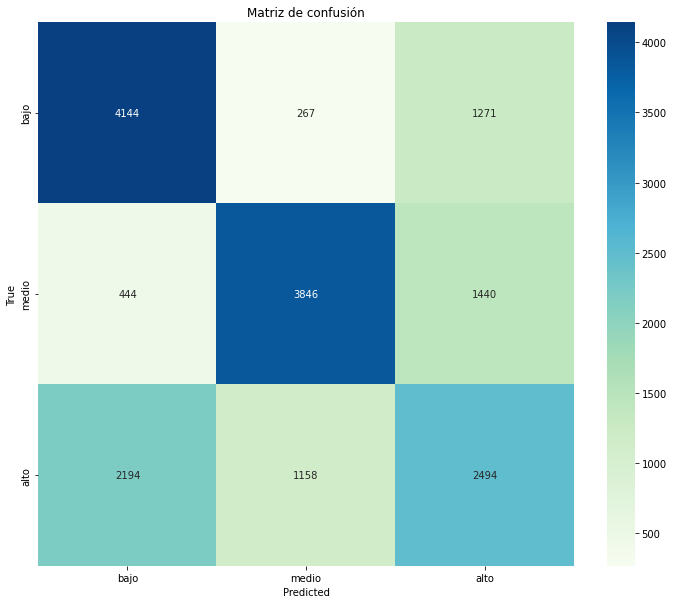


Clasification metrics

Accuracy: 0.6074863831266659
Recall: 0.6074863831266659
F1 score: 0.6039752400411846


In [73]:
def clasificar_propiedad(entrada):
  prediccion = best_model.predict(entrada)
  arg_max = np.argmax(prediccion, axis=1)
  return arg_max

y_pred = clasificar_propiedad(x_test_clasificacion)
plot_confusion_matrix(y_test_clasificacion, y_pred, outputs.keys())
print_clasification_metrics(y_test_clasificacion, y_pred)


## Regresión

In [74]:
# Creación del modelo

d_in = x_train_regresion.shape[1]
d_out = 1

# Hiperparámetros

batch_size = x_train_regresion.shape[0] // 2
learning_rate = 1

modelo_regresion = Sequential()
modelo_regresion.add(Dense(512, input_shape=(d_in,), activation='relu'))
modelo_regresion.add(Dense(128, activation='relu'))
modelo_regresion.add(Dense(32, activation='relu'))
# modelo_regresion.add(Dense(10, activation='relu'))
# modelo_regresion.add(Dense(10, activation='relu'))
# modelo_regresion.add(Dense(10, activation='relu'))
modelo_regresion.add(Dense(d_out))
  
modelo_regresion.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               33280     
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 103,105
Trainable params: 103,105
Non-trainable params: 0
_________________________________________________________________


In [75]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

modelo_regresion.compile(
  optimizer=keras.optimizers.Adam(), 
  loss = 'mse', 
  metrics = ['mae'], 
)

In [76]:
# Entrenamiento

modelo_regresion.fit(x_train_regresion, y_train_regresion, epochs=1000, batch_size = 128)

Epoch 1/1000
541/541 [==============================] - 3s 5ms/step - loss: 15602605056.0000 - mae: 87969.4297
Epoch 2/1000
541/541 [==============================] - 2s 5ms/step - loss: 2844959488.0000 - mae: 36710.5391
Epoch 3/1000
541/541 [==============================] - 2s 4ms/step - loss: 2718675712.0000 - mae: 35826.0000
Epoch 4/1000
541/541 [==============================] - 2s 5ms/step - loss: 2664696064.0000 - mae: 35448.8359
Epoch 5/1000
541/541 [==============================] - 2s 5ms/step - loss: 2637281024.0000 - mae: 35222.8477
Epoch 6/1000
541/541 [==============================] - 2s 4ms/step - loss: 2614708480.0000 - mae: 35091.4062
Epoch 7/1000
541/541 [==============================] - 2s 4ms/step - loss: 2602159616.0000 - mae: 35011.0117
Epoch 8/1000
541/541 [==============================] - 2s 4ms/step - loss: 2591203584.0000 - mae: 34941.7852
Epoch 9/1000
541/541 [==============================] - 2s 4ms/step - loss: 2582540544.0000 - mae: 34904.4766
Epoch 10/

In [77]:
y_pred_regresion = modelo_regresion.predict(x_test_regresion)

# mae_modelo_regresion = mean_absolute_error(y_test_regresion, y_pred_regresion)
# mse_modelo_regresion = mean_squared_error(y_test_regresion, y_pred_regresion)

# print(f"Error absoluto medio: {mae_modelo_regresion}")
# print(f"Error cuadrático medio: {mse_modelo_regresion}")
print_regression_metrics(y_test_regresion, y_pred_regresion)

540/540 [==============================] - 1s 2ms/step

Regression metrics

El error (mse) de test es: 1983795542.72536
El error (rmse) de test es: 44539.819742847634
El score R2 es: 0.8132574694917024
